In [1]:
import numpy as np
import sys, platform
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian, Pauli
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

print("Python full:", sys.version)          # e.g. '3.12.5 (main, ...)'
print("Python tuple:", sys.version_info)     # e.g. sys.version_info(major=3, minor=12, micro=5, ...)
print("Python short:", platform.python_version())  # e.g. '3.12.5'
print("Executable:", sys.executable)         # path to the kernel's python


Python full: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:44:42) [Clang 18.1.8 ]
Python tuple: sys.version_info(major=3, minor=12, micro=9, releaselevel='final', serial=0)
Python short: 3.12.9
Executable: /opt/homebrew/anaconda3/envs/qiskit2x/bin/python


In [2]:
## PUBs: These are the things you pass into the "run" method of the primitives:

In [3]:
## PUBs for the SamplerV2:
# Qiskit v2.x — SamplerV2 PUB example
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

# 1) Make a small parametric circuit (must include measurements for Sampler)
theta = Parameter("θ")
qc = QuantumCircuit(2)
qc.ry(theta, 0)
qc.cx(0, 1)
qc.measure_all()

# 2) Pick a backend and map to its ISA
service = QiskitRuntimeService()               # requires your IBM Quantum credentials configured
backend = service.backends()[0]                # pick any accessible backend (sim or device)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circ = pm.run(qc)                          # ISA-mapped circuit

# 3) Build iterable of PUBs (each is a tuple)
#    Here we sweep θ over two values in one PUB and set per-PUB shots.
pubs = [
    (isa_circ, [0.0, 1.234], 2000),           # PUB #1
    (isa_circ, [2.468], 4000),                # PUB #2
]

# 4) Run
sampler = SamplerV2(mode=backend)             # or SamplerV2() for some simulator modes
job = sampler.run(pubs)                       # you can also pass shots=... here globally
result = job.result()

# 5) Inspect results (shape and accessors may vary by minor bb; this prints a readable summary)
for i, pub_res in enumerate(result):
    print(f"\nPUB {i} summary:")
    print(pub_res)                            # prints distribution/metadata per PUB


/opt/homebrew/anaconda3/envs/qiskit2x/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:837: UserWarning: The backend ibm_brisbane currently has a status of maintenance.
  warnings.warn(


KeyboardInterrupt: 

In [12]:
from math import pi
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

θ = Parameter("θ")
φ = Parameter("φ")

qc = QuantumCircuit(1)
qc.ry(θ, 0)        # uses θ
qc.rz(φ, 0)        # uses φ

bound = qc.assign_parameters({θ: 0.0, φ: pi/2}, inplace=False)
print(len(qc.parameters), len(bound.parameters))

# After assigning parameters, they become values.  "parameters" only counds free parameters that haven't been assigned. s
qc.assign_parameters({θ: 0.0, φ: pi/2}, inplace=True)
print(len(qc.parameters))


2 0
0


In [ ]:
job = sampler.run(pubs, shots=1000)
prim_res = job.result()            # sequence of SamplerPubResult, len == len(pubs)

pub0 = prim_res[0]                 # SamplerPubResult for PUB #0

# A) Counts from the default register (often named "meas")
counts = pub0.data.meas.get_counts()  # -> dict like {'00': 517, '11': 483}


In [ ]:
print(counts)

In [ ]:
# Imagine this was your PUB result for a 2-qubit circuit with a single classical register "meas"
pub = result[0]                     # SamplerPubResult for PUB #0, run with shots=8

# Raw, per-shot outcomes (chronological): one string per shot
bitshots = pub.data.meas.get_bitstrings()
print(bitshots)
# Example output (WILL vary run-to-run):
# ['00','01','00','00','11','00','01','00']
#  ^0   ^1   ^2   ^3   ^4   ^5   ^6   ^7
# shot0 shot1 shot2 ...

# Aggregated histogram (orderless counts of unique outcomes):
# counts = pub.data.meas.get_counts()
# print(counts)
# {'00': 5, '01': 2, '11': 1}


In [ ]:
import numpy as np
# θ across 2 rows, φ across 4 columns:
theta = np.array([0.0, 0.8]).reshape(2,1)          # (2,1)
phi   = np.array([0.0, 0.2, 0.4, 0.6]).reshape(1,4) # (1,4)
Θ = np.broadcast_to(theta, (2,4))
Φ = np.broadcast_to(phi,   (2,4))
param_grid = np.stack([Θ, Φ], axis=-1)              # (2,4,2) -> last axis is [θ, φ]

pubs = [(isa_circ, param_grid, 512)]
res = sampler.run(pubs).result()
print(res[0].data.meas)
# BitArray(<shape=(2, 4), num_shots=512, num_bits=3>)


In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 2)   # 2 qubits, 2 classical bits
# Implicitly creates one QuantumRegister (size 2) and one ClassicalRegister (size 2)

# 1) The whole classical register (size 2)
creg = qc.cregs[0]          # ClassicalRegister
print(creg, len(creg))      # e.g., "c(2) 2"

# 2) A single classical bit: index 1 (the second bit)
cbit1 = qc.clbits[1]        # Clbit
print(cbit1)                # e.g., "c[1]"

# Using them with if_test:
#   - per-bit condition:
# with qc.if_test((cbit1, 1)):
#     qc.x(0)
#
#   - multi-bit condition on the whole register:
# with qc.if_test((creg, 0b10)):   # matches bit pattern '10' (c[1]=1, c[0]=0)
#     qc.x(0)


In [ ]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.measure([0,1],[0,1])
with qc.if_test((qc.clbits[0], 1)):
    qc.x(0)

In [ ]:
qc.t(0)

In [ ]:
qc.tdg(0)

In [ ]:
qc.draw()

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

# Create |Φ+> = (|00> + |11>)/√2
qc.h(0)
qc.cx(0, 1)

# Apply Z on qubit 0 using only H and X:  Z = H X H
qc.h(0); qc.x(0); qc.h(0)

qc.draw('mpl')


## Parameter

In [ ]:
from qiskit.quantum_info import Pauli
from qiskit.circuit import Parameter, ParameterVector
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService 

theta = Parameter('theta')
phi = Parameter('phi')
qc = QuantumCircuit(2, 2)
qc.ry(theta,0)
qc.rz(phi,0)
qc.rx(phi+theta,0)
print(qc.parameters)
qc.draw('mpl')

# produce 2 separate, bound circuits

#Case A
theta_val=0.0
phi_val = np.pi/2
qc_A=qc.assign_parameters({theta: theta_val, phi: phi_val}, inplace=False)
display(qc_A.draw('mpl'))

#Case B
theta_val= np.pi/4
phi_val = np.pi/4
qc_B=qc.assign_parameters({theta: theta_val, phi: phi_val}, inplace=False)
display(qc_B.draw('mpl'))


In [ ]:
### how to use "qc.assign_parameters"
from qiskit.circuit import QuantumCircuit, Parameter
 
# create the parameter
phi = Parameter("phi")
qc = QuantumCircuit(1)

# parameterize the rotation
qc.rx(phi, 0)
qc.draw("mpl")
 
# bind the parameters after circuit to create a bound circuit
bc = qc.assign_parameters({phi: 3.14})
bc.measure_all()
bc.draw("mpl")

### ParameterVector

In [ ]:
qc = QuantumCircuit(2)

theta_vec=ParameterVector('theta', 3)
# theta_vec=[0.1, 0.3, 0.5]
qc.ry(theta_vec[0],0)
qc.rz(theta_vec[1],0)
qc.rx(theta_vec[2],1)
qc.ry(theta_vec[0] - theta_vec[2], 1)
display(qc.draw('mpl'))
print(qc.parameters)

# Create 2 bound circuits
qc_A=qc.assign_parameters({theta_vec[0]:0.0, theta_vec[1]:np.pi/2, theta_vec[2]:np.pi/4}, inplace=False)
qc_B=qc.assign_parameters({theta_vec:[np.pi/6, np.pi/3, np.pi/2]}, inplace=False)
print(qc_A.parameters)
print(qc_B.parameters)


In [ ]:
display(qc_A.draw('mpl'))

In [ ]:
display(qc_B.draw('mpl'))

In [ ]:
## Using Estimator

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, SamplerV2

qr=QuantumRegister(3, 'myreg')
cr=ClassicalRegister(3, 'creg_a')
qc=QuantumCircuit(qr, cr)
# qc.h(2)
# qc.measure(qr,cr)
# with qc.if_test((cr[2], 1)) as else_:
#     qc.z(1)
# with else_:
#     qc.h(1)

display(qc.draw('mpl'))
sv=QiskitRuntimeService()
backend=sv.backends()[0]
pm=generate_preset_pass_manager(backend=backend, optimization_level=3)
obs=SparsePauliOp('XII')
cir_isa=pm.run(qc)
print('cir_isa is of type', type(cir_isa))
obs_isa=obs.apply_layout(cir_isa.layout)

PUB1=(cir_isa, obs_isa, [], 4)

# estimator=EstimatorV2(mode=backend,shots=4000)
estimator=EstimatorV2(mode=backend)
# job=estimator.run([(cir_isa, obs_isa)])
job=estimator.run([(cir_isa, obs_isa, None, 0.04)])
results=job.result()

print(results[0].data)

In [ ]:
## Sampler

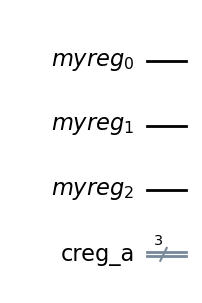

DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>))


In [9]:
## Estimator - using Aer
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp
# from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, SamplerV2
from qiskit_aer.primitives import EstimatorV2, SamplerV2

qr=QuantumRegister(3, 'myreg')
cr=ClassicalRegister(3, 'creg_a')
qc=QuantumCircuit(qr, cr)

display(qc.draw('mpl'))
# sv=QiskitRuntimeService()
# backend=sv.backends()[0]
# pm=generate_preset_pass_manager(backend=backend, optimization_level=3)#  aer
obs=SparsePauliOp('XII')
# cir_isa=pm.run(qc) #aer
# print('cir_isa is of type', type(cir_isa)) # aer
# obs_isa=obs.apply_layout(cir_isa.layout) #aer

cir_isa = qc
obs_isa = obs
PUB1 = (cir_isa, obs_isa, [], 0.04)

# estimator=EstimatorV2(mode=backend,shots=4000)
estimator=EstimatorV2()
# job=estimator.run([(cir_isa, obs_isa)])
# job=estimator.run([(cir_isa, obs_isa, None, 0.04)])
job=estimator.run([PUB1])
results=job.result()

print(results[0].data)